Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [145]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [146]:
import pandas as pd

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [147]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [148]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [149]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [150]:
df_subset = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
              (df['SALE_PRICE'] >= 100000) &
              (df['SALE_PRICE'] <= 2000000)]
df_subset['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('04/01/2019')
train = df_subset[df_subset.SALE_DATE < cutoff]
test = df_subset[df_subset.SALE_DATE >= cutoff]

C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [151]:
test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,4616 INDEPENDENCE AVENUE,NaN,...,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,NaN,A2,558 ELLSWORTH AVENUE,NaN,...,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,NaN,A1,16 BAY RIDGE PARKWAY,NaN,...,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01
18280,3,OTHER,01 ONE FAMILY DWELLINGS,1,7813,24,NaN,A5,1247 EAST 40TH STREET,NaN,...,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,2019-04-01
18285,3,OTHER,01 ONE FAMILY DWELLINGS,1,8831,160,NaN,A9,2314 PLUMB 2ND STREET,NaN,...,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,2019-04-01


In [152]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2517.0,6750.859754,3977.126707,21.0,3818.0,6021.0,9879.0,16350.0
LOT,2517.0,75.674215,157.232723,1.0,21.0,42.0,70.0,2720.0
EASE-MENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_CODE,2517.0,10993.891538,494.054748,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2517.0,0.987684,0.110315,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2517.0,0.016289,0.129712,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2517.0,1.003973,0.171453,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2517.0,1473.500596,599.132016,0.0,1144.0,1367.0,1683.0,7875.0
YEAR_BUILT,2517.0,1944.729837,27.054972,1890.0,1925.0,1940.0,1960.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,2517.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [154]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaT,NaT
BOROUGH,2517,5,4,1209,NaT,NaT
NEIGHBORHOOD,2517,6,OTHER,2390,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaT,NaT
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2517,889,"4,000",235,NaT,NaT
ADDRESS,2517,2507,104-18 187TH STREET,2,NaT,NaT


In [170]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS','LAND_SQUARE_FEET','SALE_DATE']
useless = ['EASE-MENT','APARTMENT_NUMBER']
features = train.columns.drop([target] + high_cardinality + useless)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [173]:
X_train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5


In [174]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [175]:
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,...,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [176]:
from sklearn.feature_selection import f_regression,SelectKBest

selector = SelectKBest(score_func=f_regression,k=15)

X_train_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape,X_test_selected.shape

C:\Users\julio\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\julio\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\julio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\julio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\julio\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2517, 15), (647, 15))

In [177]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3


Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF

In [153]:
# Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
#  Do one-hot encoding of categorical features.
#  Do feature selection with SelectKBest.
#  Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
#  Get mean absolute error for the test set.
#  As always, commit your notebook to your fork of the GitHub repo.

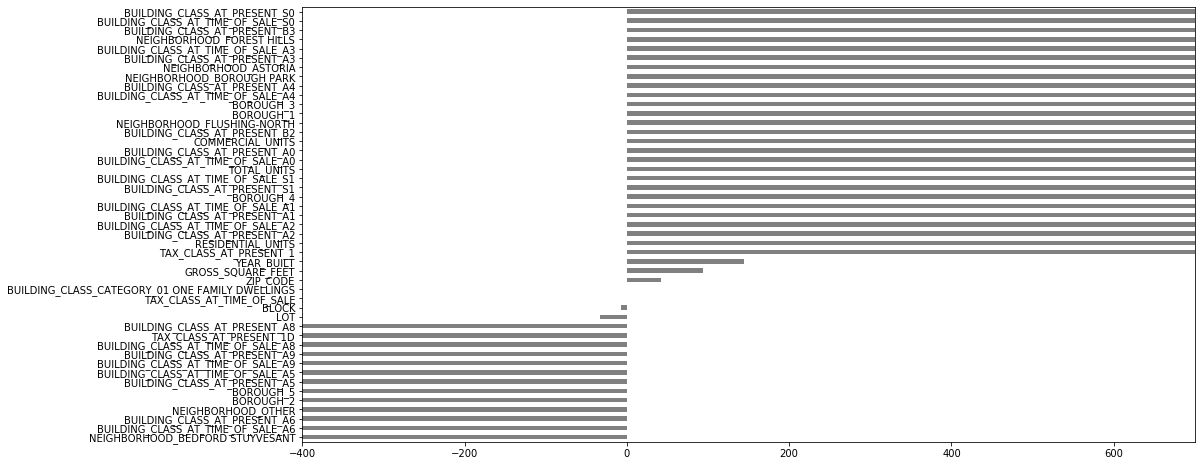

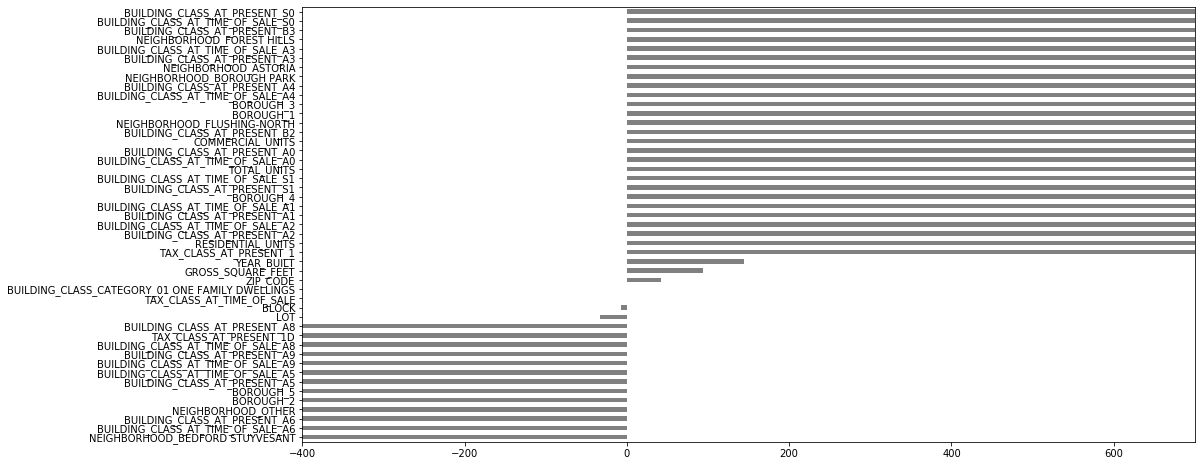

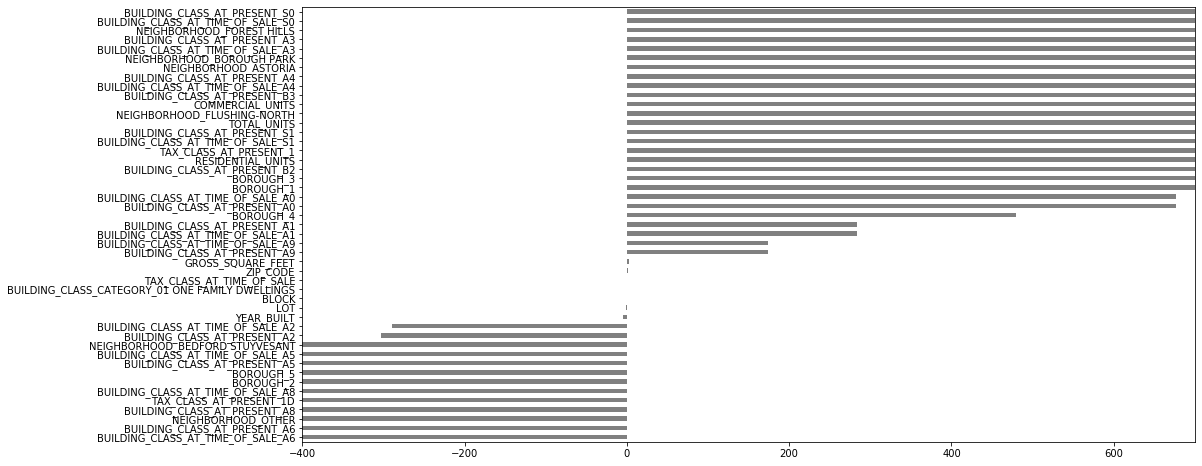

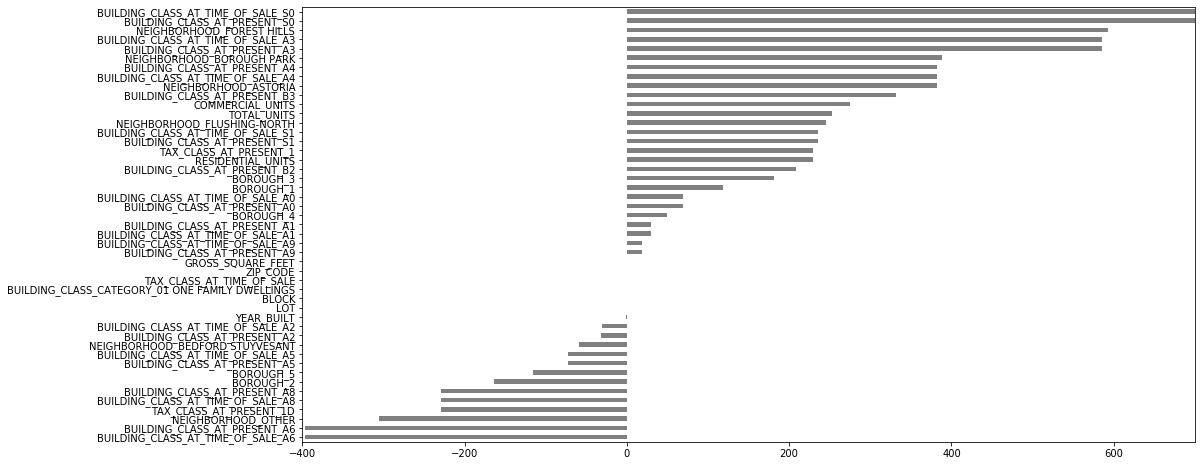

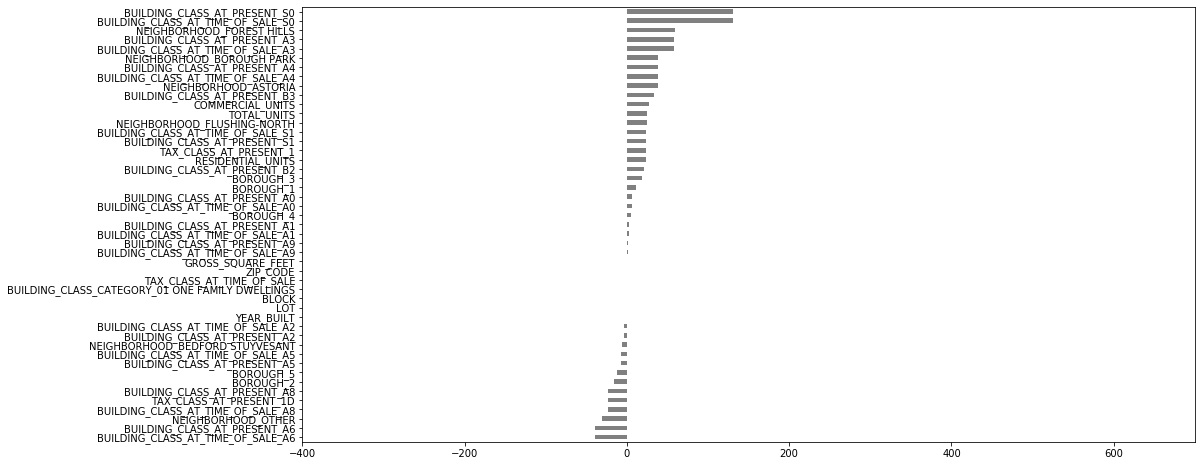

In [181]:
from IPython.display import display,HTML
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

for alpha in [1.0,1,100.0,1000.0,10000.0]:
    

    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    coefficients = pd.Series(model.coef_,X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()